In [1]:
import pandas as pd
import numpy as np

import pickle

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, VotingRegressor,StackingRegressor
from sklearn.neural_network import MLPRegressor


import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In this notebook, we will take our cleaned difference data and predict the goal difference using the supp data.

In [2]:
X = pd.read_csv('Goal_Diff_Prediction/GD_training_data.csv')
y = pd.read_csv('Goal_Diff_Prediction/Y_train_supp.csv', index_col = "ID")
y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12303 entries, 0 to 12302
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GOAL_DIFF_HOME_AWAY  12303 non-null  float64
dtypes: float64(1)
memory usage: 192.2 KB


Our approach to predicting the GD will be as follows:

 1. Using a linear model and forwards stepwise selection, we will limit the number of features in order to limit potential overfitting problems.
 2. Use various regression models to fit our data set. 
 3. Hyper-param tuning.
 4. Make GD predictions for our training data set.
 5. Save predictions and models.

Before we begin, we'll split our data

In [3]:
X_train, X_test, y_train, y_test   = train_test_split(X,y, random_state = 48,test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X,y, random_state = 48,test_size=0.2)

Before we try and fit the different models, we will have a quick look at the data:

min:-13, max: 9


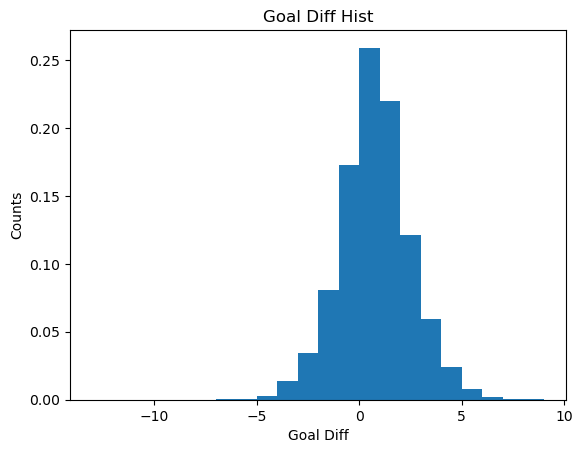

In [4]:
bins = range(int(y['GOAL_DIFF_HOME_AWAY'].min()), int(y['GOAL_DIFF_HOME_AWAY'].max()))
print(f"min:{bins[0]}, max: {bins[-1]}")
plt.hist(y, bins = bins, density=True)
plt.xlabel("Goal Diff")
plt.ylabel("Counts")
plt.title("Goal Diff Hist")
plt.show()

The problem that we are going to have when fitting is that the number of large wins/losses is quite small compared to the number of close games. If we class a close game as a draw or a goal difference of 1, then

In [5]:
frac_close = np.round(y.value_counts()[bins[12:15]].sum()/len(y),2)
print(f"fraction of games that are close: {frac_close}; fraction not close: {1-frac_close}")

fraction of games that are close: 0.65; fraction not close: 0.35


In [6]:
X_train.describe()

,Unnamed: 0,HOME_TEAM_INJURIES_season_sum,HOME_TEAM_GAME_WON_season_sum,HOME_TEAM_GAME_DRAW_season_sum,HOME_TEAM_GAME_LOST_season_sum,HOME_TEAM_SHOTS_TOTAL_season_std,HOME_TEAM_SHOTS_INSIDEBOX_season_std,HOME_TEAM_SHOTS_OFF_TARGET_season_std,HOME_TEAM_SHOTS_ON_TARGET_season_std,HOME_TEAM_SHOTS_OUTSIDEBOX_season_std,...,DIFF_TEAM_GAME_DRAW_5_last_match_sum,DIFF_TEAM_GAME_LOST_5_last_match_sum,DIFF_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_5_last_match_average,DIFF_TEAM_BALL_POSSESSION_5_last_match_average,WIN_PRIOR,DRAW_PRIOR,LOST_PRIOR,DIFF_GOOD_SHOT_season_sum,DIFF_GOOD_SHOT_5_last_match_sum,DIFF_FORM_5_last_match_sum
count,9842.000000,9842.000000,9842.000000,9842.000000,9842.000000,9842.000000,9842.000000,9842.000000,9842.000000,9842.000000,...,9842.000000,9842.000000,9842.000000,9842.000000,9842.000000,9842.000000,9842.000000,9842.000000,9842.000000,9842.000000
mean,6127.864255,4.167512,4.165341,4.550242,4.720060,4.182769,4.115094,4.005080,3.849421,3.889138,...,5.034256,5.081152,4.983662,4.963824,1.105091,1.041454,1.133541,4.982454,4.947925,5.102063
std,3556.089630,2.706530,2.895377,2.889115,2.927056,2.746855,2.594966,2.788368,2.749118,2.611589,...,2.223192,2.075357,1.846590,1.907409,1.203487,0.919095,1.208038,1.268764,1.257925,1.344228
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3049.250000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,3.500000,3.500000,4.000000,3.500000,0.226244,0.303030,0.242582,4.177031,4.122715,4.240505
50%,6128.000000,4.153921,4.000000,5.000000,5.000000,4.000000,4.000000,4.000000,3.000000,3.899202,...,5.000000,5.000000,4.962532,5.000000,0.757576,0.865385,0.769231,4.980987,4.937110,5.104998
75%,9223.750000,6.000000,6.000000,6.000000,7.000000,6.000000,6.000000,6.000000,6.000000,5.000000,...,6.500000,6.500000,6.000000,6.500000,1.622391,1.587302,1.666667,5.787730,5.742806,5.957960
max,12302.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,8.000000,10.000000,9.032123,9.033172,9.399265


## Variable Selection 

To help select the data we use we will take a forward stepwise selection approach with a linear model. Before we do that we will upsample the data set so that it is balence. 

**Note that we only do this with the training set**

In [7]:
def get_upsampled_data(X, y, n_each_class = 750): # Note that this will return quite a large array, it might need to be down sampled afterwards to make the linear response fit quicker 
    data = y.join(X).copy()
    target_feature = y.columns[0]
    class_counts = data[target_feature].value_counts()
    
    # Calculate the maximum count among all classes
    max_count = class_counts.max()
    
    # Upsample each class to match the count of the class with the maximum count
    upsampled_data = pd.DataFrame(columns = data.columns)
    for class_label, count in class_counts.items():
        class_data = data[data[target_feature] == class_label]

        if count < max_count:
            upsampled_class_data = class_data.sample(n=max_count - count, replace=True, random_state=42)            
            upsampled_data = pd.concat([upsampled_data, upsampled_class_data, class_data])
        else:
            upsampled_data = pd.concat([upsampled_data, class_data])
    
    # Shuffle the upsampled data
    upsampled_data = upsampled_data.sample(frac=1, random_state=42).reset_index(drop=True).copy()
    return upsampled_data

In [8]:
def get_fraction_of_data(data, n_each_class, target_feature):
    class_counts = data[target_feature].value_counts()
    down_sampled_data = pd.DataFrame(columns = data.columns)

    for class_label, _ in class_counts.items():
        class_data = data[data[target_feature] == class_label]
        should_replace = True if len(class_data) < n_each_class else False # Do this to make sure that we can get then right amount
        down_sampled_class_data = class_data.sample(n=n_each_class, replace=should_replace, random_state=42)            
        down_sampled_data = pd.concat([down_sampled_data, down_sampled_class_data])

    return down_sampled_data

In [9]:
upsampled_data = get_fraction_of_data(get_upsampled_data(X_train, y_train), 650, 'GOAL_DIFF_HOME_AWAY')

print(upsampled_data['GOAL_DIFF_HOME_AWAY'].value_counts())

X_train_upsampled, y_train_upsampled = upsampled_data[[c for c in X_train]].copy(), upsampled_data['GOAL_DIFF_HOME_AWAY'].copy()
print(len(X_train_upsampled))

GOAL_DIFF_HOME_AWAY
 7.0     650
 10.0    650
-7.0     650
 5.0     650
-8.0     650
 8.0     650
 9.0     650
 2.0     650
-3.0     650
-6.0     650
-1.0     650
-5.0     650
 3.0     650
 0.0     650
-9.0     650
-4.0     650
 4.0     650
-2.0     650
 1.0     650
 6.0     650
Name: count, dtype: int64
13000


### Linear Model Stepwise Selection 

In [10]:
def stepwise_selection(p, X_train, y_train):
    estimator = LinearRegression()
    selector = RFE(estimator, n_features_to_select=1)
    selector = selector.fit(X_train, y_train)
    
    lst = [(r, c) for r, c in zip(selector.ranking_, X_train.columns)]
    lst.sort(key = lambda x : x[0])
    
    return [x[1] for x in lst[:p]], selector.estimator_

In [11]:
def forward_stepwise_selection_evaluation(p, data_train, data_valid): # I think that we could turn this into a useful class
    features, _  = stepwise_selection(p, *data_train)

    train_MSE, valid_MSE = [], []
    min_val_MSE = float('inf')
    for i,f in enumerate(features):
        model = LinearRegression()
        fit_feat = features[:i+1]
        model.fit(data_train[0][fit_feat], data_train[1])
        
        train_MSE.append(mean_squared_error(model.predict(data_train[0][fit_feat]), data_train[1]))
        valid_MSE.append(mean_squared_error(model.predict(data_valid[0][fit_feat]), data_valid[1]))
        if valid_MSE[-1] < min_val_MSE:
            min_val_MSE = valid_MSE[-1]
            best_model = [model, fit_feat, model.score(data_valid[0][fit_feat], data_valid[1])]
            

    return train_MSE, valid_MSE, features, best_model
        

In [12]:
def check_predictions(prediction, true):
    r_pred = [round(float(p)) for p in prediction]
    print(f"Number of correct scores: {np.round(sum((1 for p,t in zip(r_pred, true.to_list()) if p == t))/len(true), 3)}")
    print(f"Number of correct results: {np.round(sum((1 for p,t in zip(r_pred, true.to_list()) if p == t or (p*t>0)))/len(true), 3)}")
    print(f"Number of Wins: {np.round(sum((1 for p in r_pred if p >0))/len(true), 3)};  Number of win with correct score: {np.round(sum((1 for p,t in zip(r_pred, true) if p >0 and t == p))/len(true), 3)}")
    print(f"Number of Draws: {np.round(sum((1 for p in r_pred if p ==0))/len(true), 3)}; Number of loss with correct score: {np.round(sum((1 for p,t in zip(r_pred, true) if p ==0 and t == 0))/len(true), 3)}")
    print(f"Number of Losses: {np.round(sum((1 for p in r_pred if p <0))/len(true), 3)}; Number of draw with correct score: {np.round(sum((1 for p,t in zip(r_pred, true) if p <0 and t == p))/len(true), 3)}")
    print(f"MSE: {np.round(mean_squared_error(prediction, true),3)}\n")
    print(f"{'-'*40}")

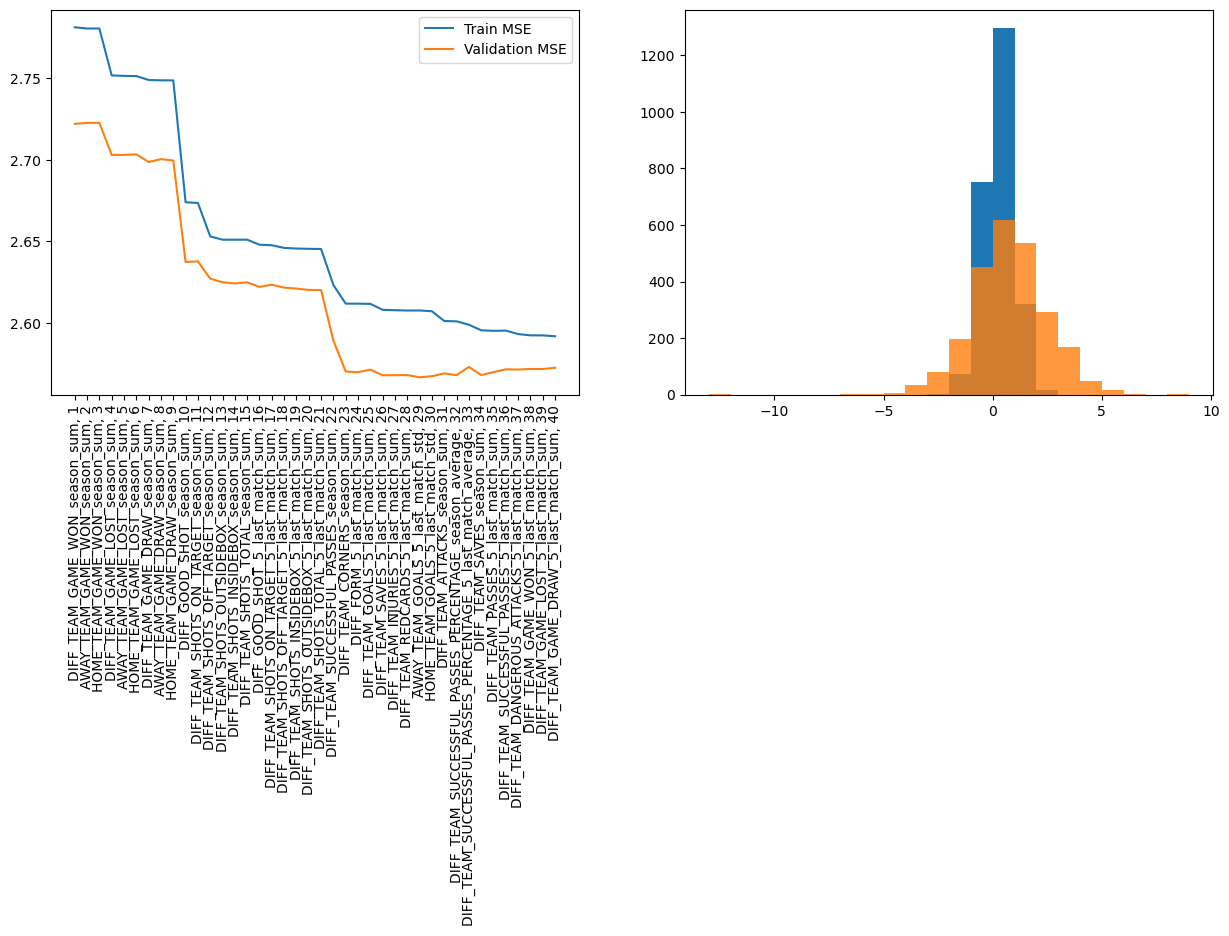

Number of correct scores: 0.268
Number of correct results: 0.429
Number of Wins: 0.347;  Number of win with correct score: 0.084
Number of Draws: 0.535; Number of loss with correct score: 0.149
Number of Losses: 0.118; Number of draw with correct score: 0.035
MSE: 2.567

----------------------------------------


In [13]:
p_max = 40
t_mse, v_mse, ranked_features, best_model =  forward_stepwise_selection_evaluation(p_max,  [X_train, y_train], 
                                                        [X_valid, y_valid])
fig, axs = plt.subplots(ncols = 2, figsize=(15, 5))

axs[0].plot(ranked_features, t_mse, label = 'Train MSE')
axs[0].plot(ranked_features, v_mse, label = 'Validation MSE')
axs[0].legend()
axs[0].set_xticks(ranked_features, labels = [f"{f}, {i+1}" for i, f in enumerate(ranked_features)], rotation = 90)

axs[1].hist(best_model[0].predict(X_valid[best_model[1]]), alpha = 1, bins = bins)
axs[1].hist(y_valid, alpha = 0.8, bins = bins)
plt.show()
check_predictions(best_model[0].predict(X_valid[best_model[1]]), y_valid['GOAL_DIFF_HOME_AWAY'])

In [14]:
print(*enumerate(best_model[1]), sep = '\n')

(0, 'DIFF_TEAM_GAME_WON_season_sum')
(1, 'AWAY_TEAM_GAME_WON_season_sum')
(2, 'HOME_TEAM_GAME_WON_season_sum')
(3, 'DIFF_TEAM_GAME_LOST_season_sum')
(4, 'AWAY_TEAM_GAME_LOST_season_sum')
(5, 'HOME_TEAM_GAME_LOST_season_sum')
(6, 'DIFF_TEAM_GAME_DRAW_season_sum')
(7, 'AWAY_TEAM_GAME_DRAW_season_sum')
(8, 'HOME_TEAM_GAME_DRAW_season_sum')
(9, 'DIFF_GOOD_SHOT_season_sum')
(10, 'DIFF_TEAM_SHOTS_ON_TARGET_season_sum')
(11, 'DIFF_TEAM_SHOTS_OFF_TARGET_season_sum')
(12, 'DIFF_TEAM_SHOTS_OUTSIDEBOX_season_sum')
(13, 'DIFF_TEAM_SHOTS_INSIDEBOX_season_sum')
(14, 'DIFF_TEAM_SHOTS_TOTAL_season_sum')
(15, 'DIFF_GOOD_SHOT_5_last_match_sum')
(16, 'DIFF_TEAM_SHOTS_ON_TARGET_5_last_match_sum')
(17, 'DIFF_TEAM_SHOTS_OFF_TARGET_5_last_match_sum')
(18, 'DIFF_TEAM_SHOTS_INSIDEBOX_5_last_match_sum')
(19, 'DIFF_TEAM_SHOTS_OUTSIDEBOX_5_last_match_sum')
(20, 'DIFF_TEAM_SHOTS_TOTAL_5_last_match_sum')
(21, 'DIFF_TEAM_SUCCESSFUL_PASSES_season_sum')
(22, 'DIFF_TEAM_CORNERS_season_sum')
(23, 'DIFF_FORM_5_last_match

We see from this plot that we should use somewhere in the range of 20-30 params. Thankfully, a few things can be noticed:

- The most important features are the number of wins and losses. It seems like all of our engineered features are doing well. 
- That the most important features are Diffs (and therefore sums) both from the season and the last 5 matches. The std terms aren't important (although note that last 5 goal std is in the form metric).
- As a classifier for our final task it is not doing too badly: it gets the correct score 25% of the time and the correct result 44%.
- There is a problem, and that is its vast overestimation of draws. I think the reason for this is the assumpition of a linear relation (the $R^2$ is only 0.12). I think a non linear model (along with oversampling the out lyers) might help. I think (and I might be wrong) that it is badly underpredicting the number of good wins (the right hand tail). We are predicting the draws correctly about 50% of the time, however we are prediciting that half of the data set are draws. 
- We **don't** use the upsampled data as it makes the fit go horribly wrong: in order to have such extreme values, the model has to make the coefficents much larger (as its a linear model), this makes the prediction in the centre much worse so when the validation score is caluculated it is rubbish.

Out of interest, lets see that if we have a quadratic model can we predict more of the outlyers. 

Number of features: 464
MSE Valid: 2.6294
MSE Train: 2.5363
----------------------------------------


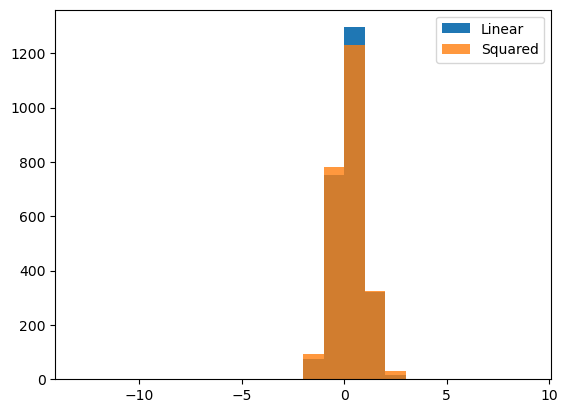

Number of correct scores: 0.26
Number of correct results: 0.419
Number of Wins: 0.347;  Number of win with correct score: 0.083
Number of Draws: 0.529; Number of loss with correct score: 0.144
Number of Losses: 0.124; Number of draw with correct score: 0.034
MSE: 2.629

----------------------------------------


In [15]:
degree = 2
def get_poly_features(X, degree):
    poly = PolynomialFeatures(degree,include_bias = False)
    X_poly = poly.fit_transform(X)
    return X_poly
    
def fitting_goals_polynomial(train_data, valid_data, degree = 1):
    X_train_poly, X_valid_poly = get_poly_features(train_data[0], degree), get_poly_features(valid_data[0], degree)
    model = LinearRegression(fit_intercept = True)
    model.fit(X_train_poly, y_train)
    print(f"Number of features: {X_train_poly.shape[1]}")
    print(f"MSE Valid: {np.round(mean_squared_error(model.predict(X_valid_poly), valid_data[1]),4)}")
    print(f"MSE Train: {np.round(mean_squared_error(model.predict(X_train_poly), train_data[1]),4)}")
    print(f"{'-'*40}")
    return model

plt.hist(best_model[0].predict(X_valid[best_model[1]]), alpha = 1, bins = bins, label = 'Linear')

model = fitting_goals_polynomial([X_train[best_model[1]], y_train], [X_valid[best_model[1]], y_valid], degree = degree)
plt.hist(model.predict(get_poly_features(X_valid[best_model[1]], degree)), bins  = bins, alpha = 0.8, label = 'Squared')
plt.legend()
plt.show()

check_predictions(model.predict(get_poly_features(X_valid[best_model[1]], degree)), y_valid['GOAL_DIFF_HOME_AWAY'])


So we do get more extreme values, however we get worse results due to overfitting (we now have approx 360 features...).


## Fitting Goal Difference

We will fit the goal difference using the follow models:

- Linear Regression
- kNN
- Random Forest
- Ada Boost 
- Bagging Regressor 
- Gradient Boosting Resgressor
- Neural Net

What we will do in the following section is fit each of the above models with both the standard training set and the up_sampled training set. We will use CV to tune the hyper params. 

In [16]:
def fit_gd_regressor(model_type, model_params = None, analytics = False, up_sampled = False):
    ''' Fits a model to the data give with the model_params. Then prints analytics so we get an idea of the model'''
    X, y = (X_train_upsampled[best_model[1]], y_train_upsampled) if up_sampled else (X_train[best_model[1]], y_train)
    
    model_params = {} if model_params is None else model_params
    
    model = model_type(**model_params)
    model.fit(X, y)

    if analytics:
        print(model_params)
        print(f"MSE Valid: {np.round(mean_squared_error(model.predict(X_valid[best_model[1]]), y_valid['GOAL_DIFF_HOME_AWAY']),4)}")
        print(f"MSE Train: {np.round(mean_squared_error(model.predict(X[best_model[1]]), y),4)}")
        check_predictions(model.predict(X_valid[best_model[1]]), y_valid['GOAL_DIFF_HOME_AWAY'])
        
    return model

In [17]:
def find_gd_hyperparams(estimator, param_grid, up_sampled):
    '''Grid Searches for the best hyper params using CV, then return the best model fitting on the data'''
    X, y = (X_train_upsampled[best_model[1]], y_train_upsampled) if up_sampled else (X_train[best_model[1]], y_train)
    
    clf = GridSearchCV(estimator = estimator(), param_grid=param_grid, verbose = 1)
    clf.fit(X, y)
    return clf.best_params_

#### Linear 

In [28]:
ridge_hyper_params = {'alpha' : np.linspace(2330,2350)}
ridge_normal_hyp = find_gd_hyperparams(Ridge, ridge_hyper_params, False)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [29]:
print('Normal Sampling')
linear_normal = fit_gd_regressor(Ridge,ridge_normal_hyp, analytics = True, up_sampled = False);

Normal Sampling
{'alpha': 2342.2448979591836}
MSE Valid: 2.5695
MSE Train: 2.6089
Number of correct scores: 0.271
Number of correct results: 0.429
Number of Wins: 0.341;  Number of win with correct score: 0.084
Number of Draws: 0.544; Number of loss with correct score: 0.153
Number of Losses: 0.114; Number of draw with correct score: 0.034
MSE: 2.569

----------------------------------------


#### KNN

Note, if the hyper params only contains one set of values, it is because we have found the best fit and only left those values there. 

In [30]:
knn_hyper_params = {'n_neighbors' : range(45,55), 
                    'p' :[1]}
KNN_normal_hyp = find_gd_hyperparams(KNeighborsRegressor, knn_hyper_params, False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [31]:
print('Normal Sampling')
KNN_normal = fit_gd_regressor(KNeighborsRegressor, KNN_normal_hyp, analytics = True, up_sampled = False);

Normal Sampling
{'n_neighbors': 53, 'p': 1}
MSE Valid: 2.6175
MSE Train: 2.569
Number of correct scores: 0.269
Number of correct results: 0.413
Number of Wins: 0.328;  Number of win with correct score: 0.081
Number of Draws: 0.573; Number of loss with correct score: 0.158
Number of Losses: 0.099; Number of draw with correct score: 0.03
MSE: 2.618

----------------------------------------


#### Random Forrest

In [32]:
rf_hyper_params = {'n_estimators' : [195], 
                    'min_samples_split' :[11],
                  'criterion' :['squared_error'],
                  'max_depth' : [3],
                  'max_features' : ['sqrt']}
rf_normal_hyp = find_gd_hyperparams(RandomForestRegressor, rf_hyper_params, False)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [33]:
print('Normal Sampling')
rf_normal = fit_gd_regressor(RandomForestRegressor, rf_normal_hyp, analytics = True, up_sampled = False);

Normal Sampling
{'criterion': 'squared_error', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 11, 'n_estimators': 195}
MSE Valid: 2.6459
MSE Train: 2.6416
Number of correct scores: 0.267
Number of correct results: 0.395
Number of Wins: 0.307;  Number of win with correct score: 0.073
Number of Draws: 0.637; Number of loss with correct score: 0.175
Number of Losses: 0.056; Number of draw with correct score: 0.02
MSE: 2.646

----------------------------------------


#### Adaboost

In [34]:
ada_hyper_params = {'n_estimators' : range(5,15), 
                   'loss': ['linear', 'square', 'exponential']}

ada_normal_hyp = find_gd_hyperparams(AdaBoostRegressor, ada_hyper_params, False)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [35]:
print('Normal Sampling')
ada_normal = fit_gd_regressor(AdaBoostRegressor, ada_normal_hyp, analytics = True, up_sampled = False);

Normal Sampling
{'loss': 'linear', 'n_estimators': 14}
MSE Valid: 2.6327
MSE Train: 2.6186
Number of correct scores: 0.257
Number of correct results: 0.42
Number of Wins: 0.376;  Number of win with correct score: 0.095
Number of Draws: 0.503; Number of loss with correct score: 0.134
Number of Losses: 0.121; Number of draw with correct score: 0.028
MSE: 2.633

----------------------------------------


#### Bagging 

In [36]:
bag_hyper_params = {'max_features' : [13], #range(10,18),
                   'max_samples' : [23], #range(18,25),
                   'n_estimators' : [56]}#range(53,60)}

bag_normal_hyp = find_gd_hyperparams(BaggingRegressor, bag_hyper_params, False)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [37]:
print('Normal Sampling')
bag_normal = fit_gd_regressor(BaggingRegressor, bag_normal_hyp, analytics = True, up_sampled = False);

Normal Sampling
{'max_features': 13, 'max_samples': 23, 'n_estimators': 56}
MSE Valid: 2.6874
MSE Train: 2.6965
Number of correct scores: 0.265
Number of correct results: 0.415
Number of Wins: 0.338;  Number of win with correct score: 0.078
Number of Draws: 0.546; Number of loss with correct score: 0.153
Number of Losses: 0.116; Number of draw with correct score: 0.034
MSE: 2.687

----------------------------------------


#### Gradient Boost

In [38]:
boost_hyper_params = {'n_estimators' : [21], #range(19,23,1),
                     'criterion' : ['squared_error'],
                     'learning_rate' : [0.095],
                     'subsample' : [0.71]}
boost_normal_hyp = find_gd_hyperparams(GradientBoostingRegressor, boost_hyper_params, False)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [39]:
boost_normal = fit_gd_regressor(GradientBoostingRegressor, boost_normal_hyp, analytics = True, up_sampled = False);

{'criterion': 'squared_error', 'learning_rate': 0.095, 'n_estimators': 21, 'subsample': 0.71}
MSE Valid: 2.6206
MSE Train: 2.5867
Number of correct scores: 0.269
Number of correct results: 0.403
Number of Wins: 0.31;  Number of win with correct score: 0.074
Number of Draws: 0.623; Number of loss with correct score: 0.173
Number of Losses: 0.066; Number of draw with correct score: 0.022
MSE: 2.621

----------------------------------------


#### NN 

In [40]:
nn_hyper_params = {'hidden_layer_sizes' : [(100,)],
                     'activation': ['logistic'],
                      'early_stopping' : [True]}

nn_normal_hyp = find_gd_hyperparams(MLPRegressor, nn_hyper_params, False)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [41]:
nn_normal = fit_gd_regressor(MLPRegressor, nn_normal_hyp, analytics = True, up_sampled = False);

{'activation': 'logistic', 'early_stopping': True, 'hidden_layer_sizes': (100,)}
MSE Valid: 2.5736
MSE Train: 2.6054
Number of correct scores: 0.273
Number of correct results: 0.439
Number of Wins: 0.372;  Number of win with correct score: 0.092
Number of Draws: 0.509; Number of loss with correct score: 0.145
Number of Losses: 0.119; Number of draw with correct score: 0.037
MSE: 2.574

----------------------------------------


### Stacking Regressor

Looking at the MSE we will use all the model, bar the random forest as it seems to be massively overfitting

#### Stacking the Balanced Data 

In [44]:
normal_regressors = [('l', linear_normal), 
                     ('kNN', KNN_normal),
                     ('RF', rf_normal),
                     ('ADA', ada_normal), 
                     ('BAG', bag_normal),
                     ('Boost',boost_normal), 
                     ('NN',nn_normal)]

normal_stack = VotingRegressor(normal_regressors)
normal_stack.fit(X_train[best_model[1]], y_train)
print(f"MSE Valid: {np.round(mean_squared_error(normal_stack.predict(X_valid[best_model[1]]), y_valid['GOAL_DIFF_HOME_AWAY']),4)}")
print(f"MSE Train: {np.round(mean_squared_error(normal_stack.predict(X_train[best_model[1]]), y_train['GOAL_DIFF_HOME_AWAY']),4)}")
check_predictions(normal_stack.predict(X_valid[best_model[1]]), y_valid['GOAL_DIFF_HOME_AWAY'])

MSE Valid: 2.5945
MSE Train: 2.5955
Number of correct scores: 0.27
Number of correct results: 0.421
Number of Wins: 0.35;  Number of win with correct score: 0.083
Number of Draws: 0.566; Number of loss with correct score: 0.16
Number of Losses: 0.084; Number of draw with correct score: 0.027
MSE: 2.595

----------------------------------------


## Saving Data

Before we save the models, let test the predictions on the test data:

In [45]:
print("Train MSE: ", np.round(mean_squared_error(normal_stack.predict(X_train[best_model[1]]), y_train['GOAL_DIFF_HOME_AWAY']),4))
print("Valid MSE: ", np.round(mean_squared_error(normal_stack.predict(X_valid[best_model[1]]), y_valid['GOAL_DIFF_HOME_AWAY']),4))
print("Test MSE: ", np.round(mean_squared_error(normal_stack.predict(X_test[best_model[1]]), y_test['GOAL_DIFF_HOME_AWAY']),4))

Train MSE:  2.5955
Valid MSE:  2.5945
Test MSE:  2.5945


i.e. its working.

let us now save the models to file

In [46]:
model_features = pd.DataFrame({'Feature' : best_model[1]}) # This will allow us to read in the features for the model
model_features.to_csv('Goal_Diff_Prediction/Features.csv', index = False)

In [47]:
with open('Goal_Diff_Prediction/normal_sampled_DG_predictor.pkl', 'wb') as f:
    pickle.dump(normal_stack, f)

## Conclusion 

In this notebook we have created a model to predict the GD in the match, using the most important features selected via forwards stepwise selection. 

We have trained a variety of regressive models on the data. We have tuned the hyperparams to ensure that the model is note overfitting the data -- this is particularly important for the tree based models. 

We then stack the different estimators, to give a final prediction. This estimator works well on the test set giving a MSE of $2.48$.

We note that our engineered features are important.